# Introduction to Hyperdimensional (HD) Computing
## Goal of this notebook:
### Introduce HD concepts 
### Construct a simple HD classifier for 2D data
### Compare to off-the-shelf classifiers

In [52]:
!pip install matplotlib seaborn scikit-learn numpy pandas
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
rs = RandomState(MT19937(SeedSequence(123456789)))
import math
import pandas as pd

## Asumptions: 
### We will assume binary vectors - vectors with zero and one in them
### The concepts here are easily extended to other hyperdimensional representations like polar (-1, +1), ternary (0, -1, 1) etc.
### We will work with 2-dimensional synthetic data in this notebook
### Example random binary vector of 8 dims below

In [53]:
rs.binomial(n=1, p=0.5, size=(8, 1)).squeeze().tolist()

[0, 0, 1, 1, 1, 0, 0, 1]

## Distribution of distance between random binary vectors
### As the number of dims increases, the HD vectors become equidistant with hamming distance equal to half of the dims
### In real-valued vectors, the vectors become orthogonal and equidistant in terms of cosine distance

/var/folders/_t/z_f_cv6s22gb9t3qffyg9ycnbbx9s9/T/ipykernel_91799/1196044338.py:13: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(np.array(norm_dists), bw=0.5, label=str(d))
/var/folders/_t/z_f_cv6s22gb9t3qffyg9ycnbbx9s9/T/ipykernel_91799/1196044338.py:13: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(np.array(norm_dists), bw=0.5, label=str(d))
/var/folders/_t/z_f_cv6s22gb9t3qffyg9ycnbbx9s9/T/ipykernel_91799/1196044338.py:13: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update you

[0.5055, 0.500125, 0.496828125, 0.50185546875, 0.5001838521400778, 0.5002275390625]
[0.16965332298543404, 0.12443616586426953, 0.06402016703437577, 0.030810229606627177, 0.015080308537117173, 0.0076622724241031705]


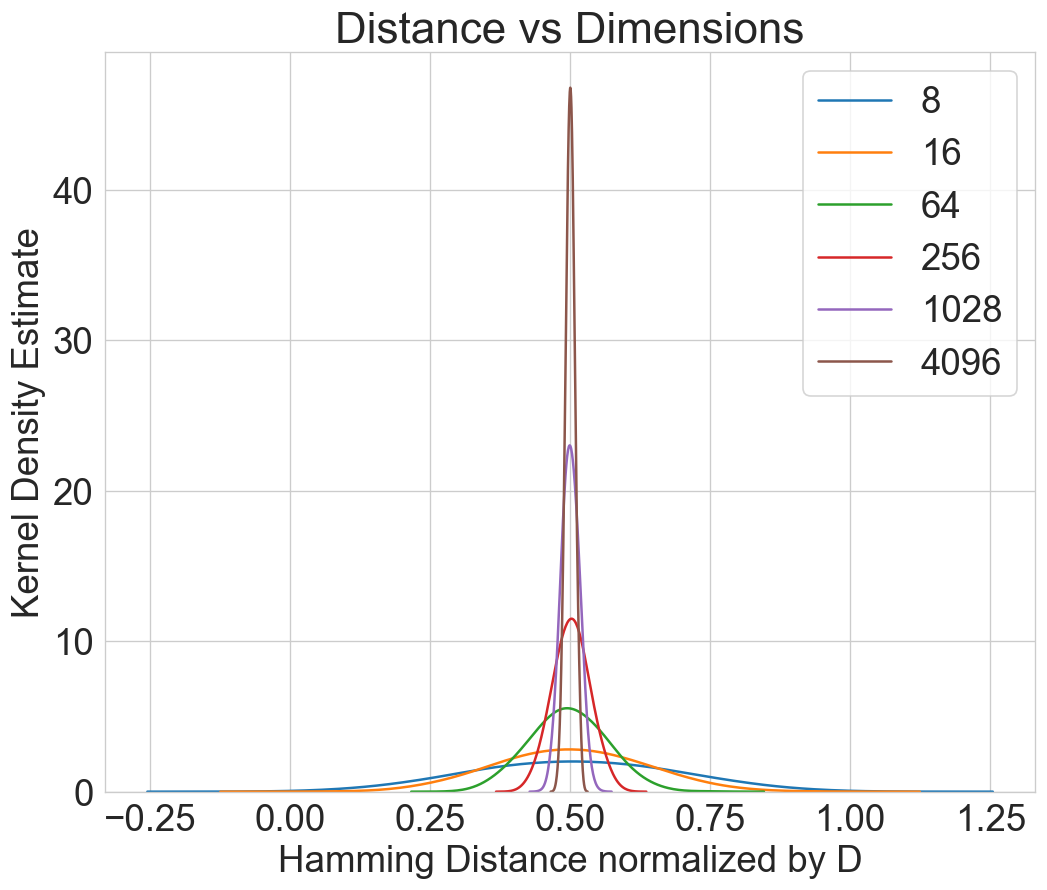

In [54]:
dims = [8, 16, 64, 256, 1028, 4096]
nsamp = 1000
dists_mean = []
dists_std = []
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,8), dpi=120)
for d in dims:
    rand1 = rs.binomial(n=1, p=0.5, size=(d, nsamp))
    rand2 = rs.binomial(n=1, p=0.5, size=(d, nsamp))
    xor = rand1 * (1-rand2) + rand2 * (1-rand1)
    d_dists = np.sum(xor, axis=0)
    norm_dists = d_dists / (1. * d)
    sns.kdeplot(np.array(norm_dists), bw=0.5, label=str(d))
    dists_mean.append( np.mean(norm_dists) )
    dists_std.append( np.std(norm_dists) )
plt.legend()
plt.xlabel('Hamming Distance normalized by D')
plt.ylabel('Kernel Density Estimate')
plt.title('Distance vs Dimensions')
print(dists_mean)
print(dists_std)

## Bundling
### Average of `n` HD vectors, followed by thresholding at `n/2` 

In [55]:
%%latex
$$b(v_1, \ldots, v_n) = \mathbf{1}(\frac{1}{n} \sum_{i=1}^n v_i \geq \frac{n}{2})$$

<IPython.core.display.Latex object>

In [56]:
lut = rs.binomial(n=1, p=.5, size=(3, 8))
ham = lambda a,b: np.abs(a - b).sum()
print(ham(lut[0], lut[2]))
bundle_example = (lut[0] + lut[2] + 1) // 2
print(ham(bundle_example, lut[0]), ham(bundle_example, lut[2]))

2
1 1


## Binding
### In the binary case, binding two HD vectors is performed by XOR

In [57]:
%%latex
$$a \oplus b = [ a \land (1-b) ] \vee [ b \land (1-a) ]$$
$$a \oplus b = a * (1-b) + b * (1-a)$$
$$a \oplus (a \oplus b) = b$$
$$b \oplus (a \oplus b) = a$$

<IPython.core.display.Latex object>

In [58]:
xor = lambda a,b: a*(1-b) + b*(1-a)
one_hd = rs.binomial(n=1, p=.5, size=(8,))
other_hd = rs.binomial(n=1, p=.5, size=(8,))
bind = xor(one_hd, other_hd)
assert bind.sum() == ham(one_hd, other_hd)
assert np.allclose(xor(bind, one_hd), other_hd)
assert np.allclose(xor(bind, other_hd), one_hd)
print(one_hd, other_hd, bind, xor(bind, one_hd), xor(bind, other_hd))

[1 0 0 1 0 0 1 0] [1 0 1 1 1 1 0 1] [0 0 1 0 1 1 1 1] [1 0 1 1 1 1 0 1] [1 0 0 1 0 0 1 0]


## Make a lookup table of random HD vectors
### This LUT maps index in `[0, ..., nvalues]` to HD vector
### Neighboring entries in LUT correspond to similar values e.g., `[0., 0.1, 0.2, ..., 0.9, 1.]` correspond to `[0, ..., nvalues]`
### My vectors are such that consecutive vectors will have hamming distance = dims//nvalues
### For example, for 16 values and 64 dims, 4 bits different between consecutive entries in the LUT
### Remark: Previously we looked at random HD vectors. Now our HD vectors are correlated.
### Similar values in the domain correspond to similar HD encoding

In [59]:
def make_LUT(nvalues, dims):
    lut = np.zeros(shape=(nvalues+1, dims))
    lut[0, :] = rs.binomial(n=1, p=0.5, size=(dims))
    for row in range(1, nvalues):
        lut[row, :] = lut[row-1, :]
        # flip few randomly
        rand_idx = rs.choice(dims, size=dims//nvalues, replace=False)
        lut[row, rand_idx] = 1 - lut[row, rand_idx]
        assert np.abs(lut[row, :] - lut[row-1, :]).sum() ==dims//nvalues 
    unique_rows = np.unique(lut, axis=0)
    assert len(unique_rows) == len(lut)
    return lut

## With this LUT we can encode quantied values
### Lets make a simple scalar quantizer for real values to `[0, ..., nvalues]` **bins**
### Construct equally spaced bins from the data
### Map values to bins using euclidean distance

In [60]:
def quantize(X, bits=4, x_bins=None, y_bins=None):
    if x_bins is None:
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        x_step = ( x_max - x_min ) / (2. ** bits)
        x_bins = np.arange(x_min, x_max + .5*x_step, x_step)
    x_all_pairs_dist = abs(X[:, 0, np.newaxis] - x_bins[np.newaxis, :])
    x_closest_bin = np.argmin(x_all_pairs_dist, axis=-1)
    quantized_x = x_bins[x_closest_bin]
    # do the same for y
    if y_bins is None:
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        y_step = ( y_max - y_min ) / (2. ** bits)
        y_bins = np.arange(y_min, y_max + .5*y_step, y_step)
    y_all_pairs_dist = abs(X[:, 1, np.newaxis] - y_bins[np.newaxis, :])
    y_closest_bin = np.argmin(y_all_pairs_dist, axis=-1)
    quantized_y = y_bins[y_closest_bin]
    return quantized_x, quantized_y, x_bins, y_bins, x_closest_bin, y_closest_bin


## Test the quantizer with random 2D points

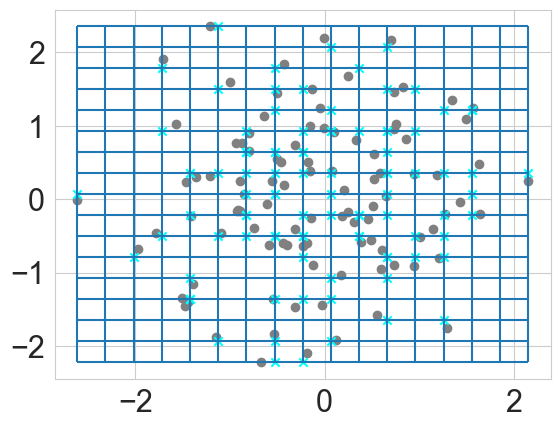

In [61]:
X = rs.multivariate_normal(mean=[0., 0.], cov=[[1., 0.], [0., 1.]] , size=100)
qx, qy, xb, yb, xidx, yidx = quantize(X)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], marker='o', c='gray')
plt.hlines(yb, xb[0], xb[-1])
plt.vlines(xb, yb[0], yb[-1])
plt.scatter(qx, qy, marker='x', c='cyan')
# Quantizing again with same bins should not change the values
assert np.allclose(quantize(X, math.log2(xb.shape[0]), xb, yb)[-1], yidx)
assert np.allclose(quantize(X, math.log2(xb.shape[0]), xb, yb)[-2], xidx)

# Create a random classification problem in 2D

In [62]:
from sklearn.datasets import make_circles, make_classification, make_moons

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, n_samples=100
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0, n_samples=100),
    make_circles(noise=0.2, factor=0.5, random_state=1, n_samples=100),
    linearly_separable,
]

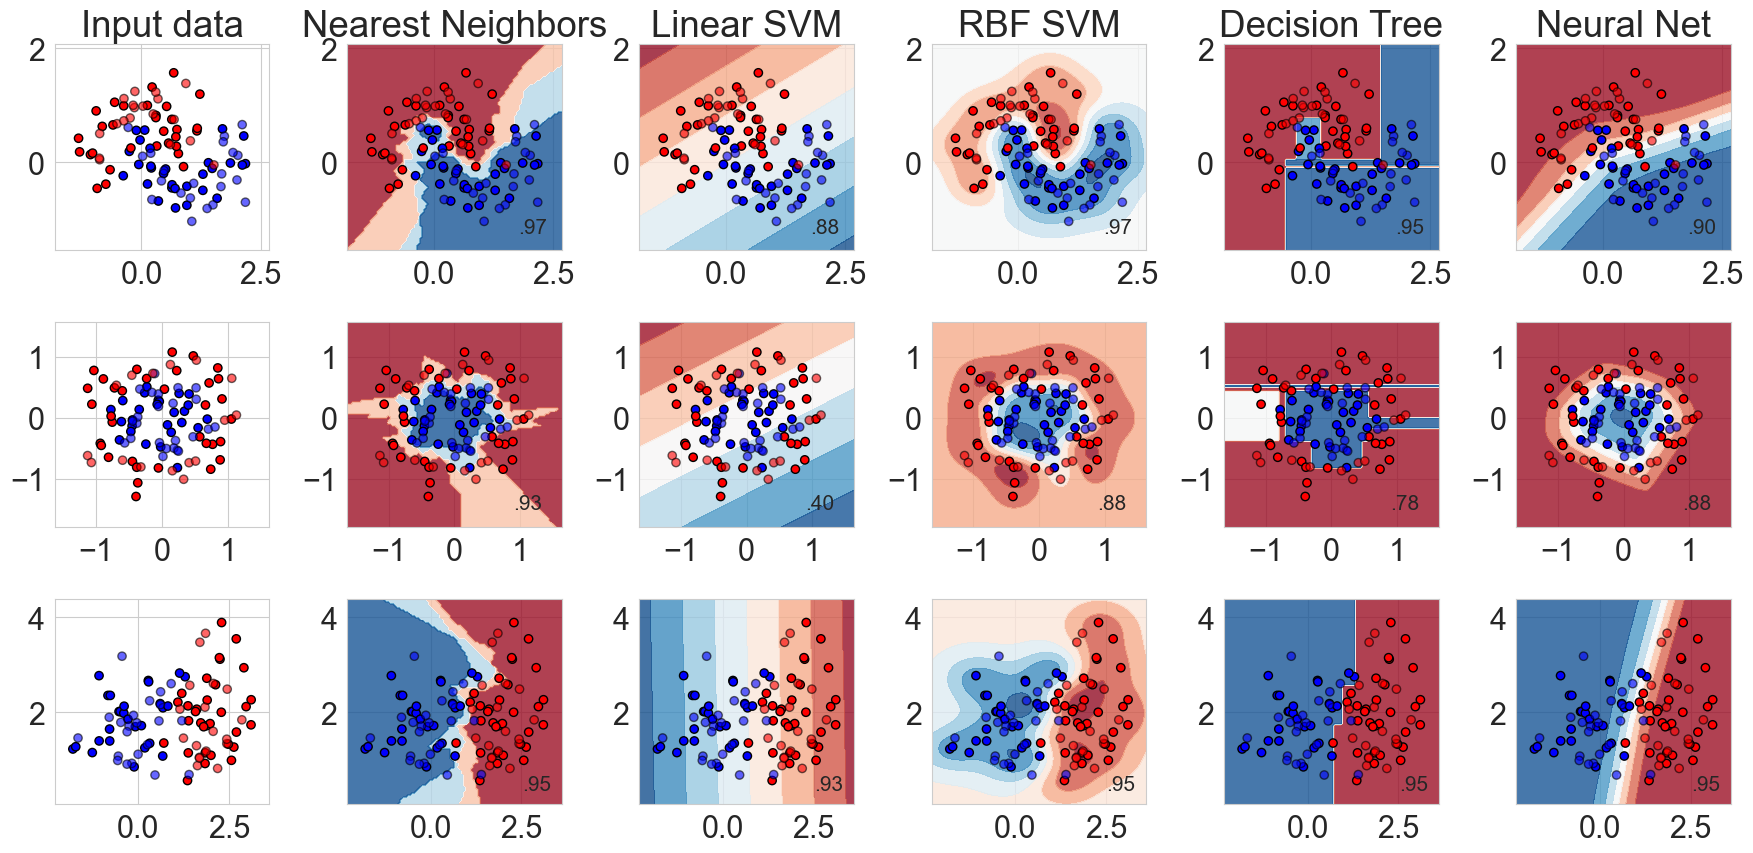

[{'Nearest Neighbors': 0.975,
  'Linear SVM': 0.875,
  'RBF SVM': 0.975,
  'Decision Tree': 0.95,
  'Neural Net': 0.9},
 {'Nearest Neighbors': 0.925,
  'Linear SVM': 0.4,
  'RBF SVM': 0.875,
  'Decision Tree': 0.775,
  'Neural Net': 0.875},
 {'Nearest Neighbors': 0.95,
  'Linear SVM': 0.925,
  'RBF SVM': 0.95,
  'Decision Tree': 0.95,
  'Neural Net': 0.95}]

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    # "Gaussian Process",
    "Decision Tree",
    # "Random Forest",
    "Neural Net",
    # "AdaBoost",
    # "Naive Bayes",
    # "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    # RandomForestClassifier(
    #     max_depth=5, n_estimators=10, max_features=1, random_state=42
    # ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    # AdaBoostClassifier(random_state=42),
    # GaussianNB(),
    # QuadraticDiscriminantAnalysis(),
]

test_acc = []

figure = plt.figure(figsize=(18, 9))
i = 1

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    test_acc.append(dict())
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    # ax.set_xticks(())
    # ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        test_acc[ds_cnt][name] = score
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # ax.set_xticks(())
        # ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()
test_acc

## Building an HD classifier: classification by clustering
### Encode all training examples to HD using the LUT above
### Form an exemplar for each label by clustering the examples in HD space 
### The cluster center is simply the average or binding of HD encoding

In [64]:
def fit(X, y, bits = 4, hyperdims = 64):
    qx, qy, xb, yb, xidx, yidx = quantize(X, bits)
    x_lut = make_LUT(2**bits, hyperdims)
    y_lut = make_LUT(2**bits, hyperdims)
    # Position HD encoding for combining X and Y
    x_pos = rs.binomial(n=1, p=0.5, size=(hyperdims))
    y_pos = rs.binomial(n=1, p=0.5, size=(hyperdims))
    # Use LUT
    x_hd = x_lut[xidx]
    y_hd = y_lut[yidx]

    bundle = lambda a,b: (1+a+b)//2
    combined = bundle( xor(x_pos[np.newaxis, ...], x_hd),
                        xor(y_pos[np.newaxis, ...], y_hd) )

    # all_pairs_dist = np.sum(np.abs(combined[:, np.newaxis, ...] - combined[np.newaxis, ...]), axis=-1) / hyperdims
    # all_pairs_dist.mean(), all_pairs_dist.std()

    # exemplars - this is just bundling 
    ex_0 = combined[y==0]
    ex_0 = np.sum(ex_0, axis=0) / ex_0.shape[0]
    ex_0[ex_0 >=  0.5] = 1.
    ex_0[ex_0 <  0.5] = 0.

    # do same
    ex_1 = combined[y==1]
    ex_1 = np.sum(ex_1, axis=0) / ex_1.shape[0]
    ex_1[ex_1 >=  0.5] = 1.
    ex_1[ex_1 <  0.5] = 0.

    # train acc
    ham0 = np.sum(np.abs(ex_0[np.newaxis, :] - combined), axis=1)
    ham1 = np.sum(np.abs(ex_1[np.newaxis, :] - combined), axis=1)
    preds = np.zeros_like(y)
    preds[ham1 < ham0] = 1
    return ex_0, ex_1, np.sum(preds == y) / len(y), x_lut, y_lut, xb, yb, x_pos, y_pos, preds

## Predict function using the HD exemplars

In [65]:
def score(exemplar_0, exemplar_1, X, y, x_bins, y_bins, x_lut, y_lut, x_pos, y_pos):
    qx, qy, xb, yb, xidx, yidx = quantize(X, bits=math.log2(x_bins.shape[0]), x_bins=x_bins, y_bins=y_bins)
    x_hd = x_lut[xidx]
    y_hd = y_lut[yidx]
    # combine with pos

    xor = lambda a,b: a*(1-b) + b*(1-a)
    combined = xor(x_pos[np.newaxis, ...], x_hd) + xor(y_pos[np.newaxis, ...], y_hd) 
    combined = (1+combined) // 2

    # test acc
    ham0 = np.sum(np.abs(exemplar_0[np.newaxis, :] - combined), axis=1)
    ham1 = np.sum(np.abs(exemplar_1[np.newaxis, :] - combined), axis=1)
    preds = np.zeros_like(y)
    preds[ham1 < ham0] = 1
    return preds, np.sum(preds == y) / len(y)

## Let's try it out on the 2D datasets

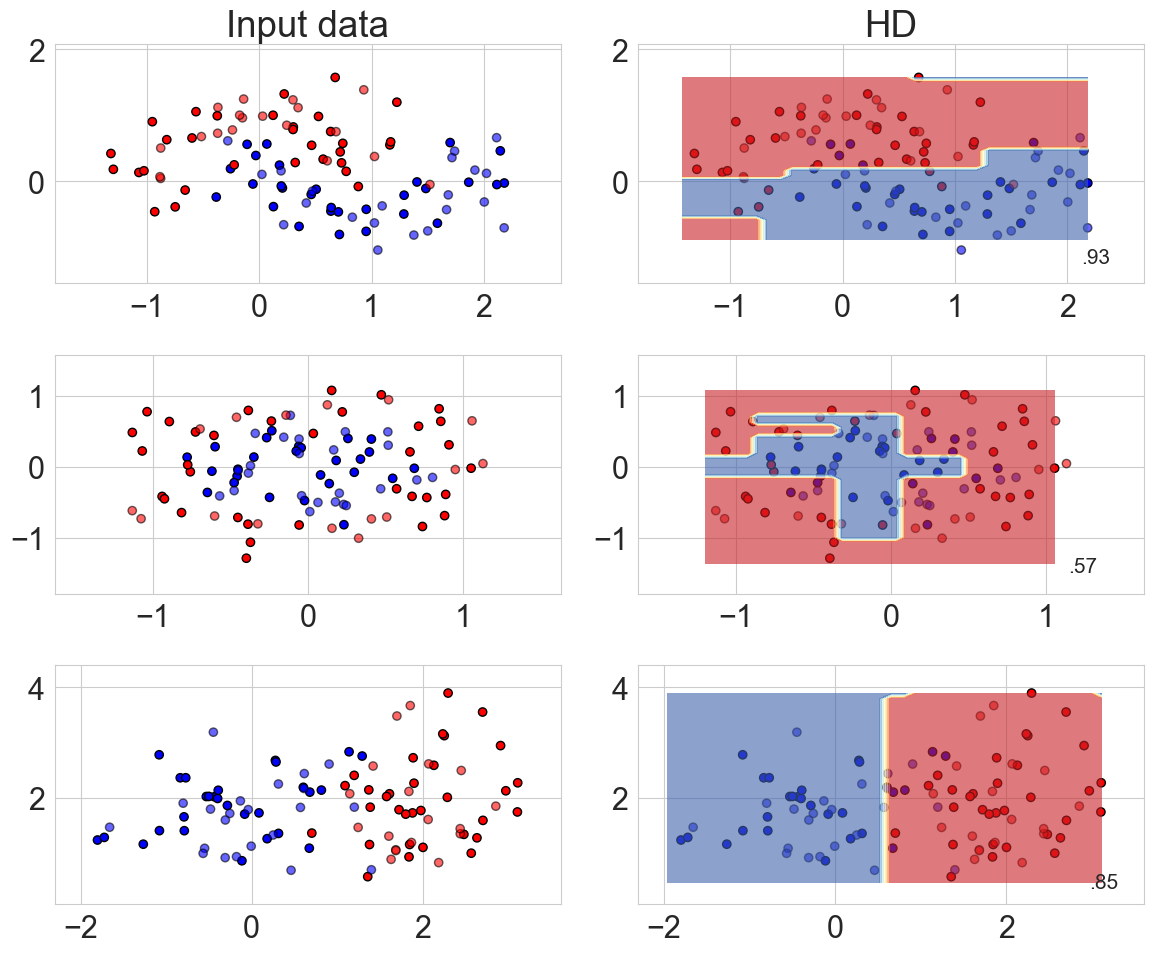

[{'Nearest Neighbors': 0.975,
  'Linear SVM': 0.875,
  'RBF SVM': 0.975,
  'Decision Tree': 0.95,
  'Neural Net': 0.9,
  'HD': 0.925},
 {'Nearest Neighbors': 0.925,
  'Linear SVM': 0.4,
  'RBF SVM': 0.875,
  'Decision Tree': 0.775,
  'Neural Net': 0.875,
  'HD': 0.575},
 {'Nearest Neighbors': 0.95,
  'Linear SVM': 0.925,
  'RBF SVM': 0.95,
  'Decision Tree': 0.95,
  'Neural Net': 0.95,
  'HD': 0.85}]

In [66]:
figure = plt.figure(figsize=(12, 10))
i = 1
names = ["HD"]
classifiers = [1]
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    # ax.set_xticks(())
    # ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        ex_0, ex_1, train_acc, x_lut, y_lut, xb, yb, x_pos, y_pos, train_preds = fit(X_train, y_train, bits=4, hyperdims=64)
        test_preds, score_test = score(ex_0, ex_1, X_test, y_test, xb, yb, x_lut, y_lut, x_pos, y_pos)
        test_acc[ds_cnt][name] = score_test
        
        # DecisionBoundaryDisplay.from_estimator(
        #     clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        # )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", 
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # ax.set_xticks(())
        # ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score_test).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

        xx, yy = np.meshgrid( np.arange(start=xb[0] - 0.5 * (xb[1]-xb[0]), stop=xb[-1] + 0.5 * (xb[1]-xb[0]), step=0.5 * (xb[1]-xb[0])), 
                                        np.arange(start=yb[0] - 0.5 * (yb[1]-yb[0]), stop=yb[-1] + 0.5 * (yb[1]-yb[0]), step=0.5 * (yb[1]-yb[0])) )
        xin = np.c_[xx.ravel(), yy.ravel()]
        y_pred, _ = score(ex_0, ex_1, xin, np.zeros(xin.shape[0]), xb, yb, x_lut, y_lut, x_pos, y_pos)
        y_pred = np.round(y_pred).reshape(xx.shape)
        ax.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.6)
        

plt.tight_layout()
plt.show()
test_acc



## Increasing num. of dimensions usaully improves performance
### 64 to 256 dims

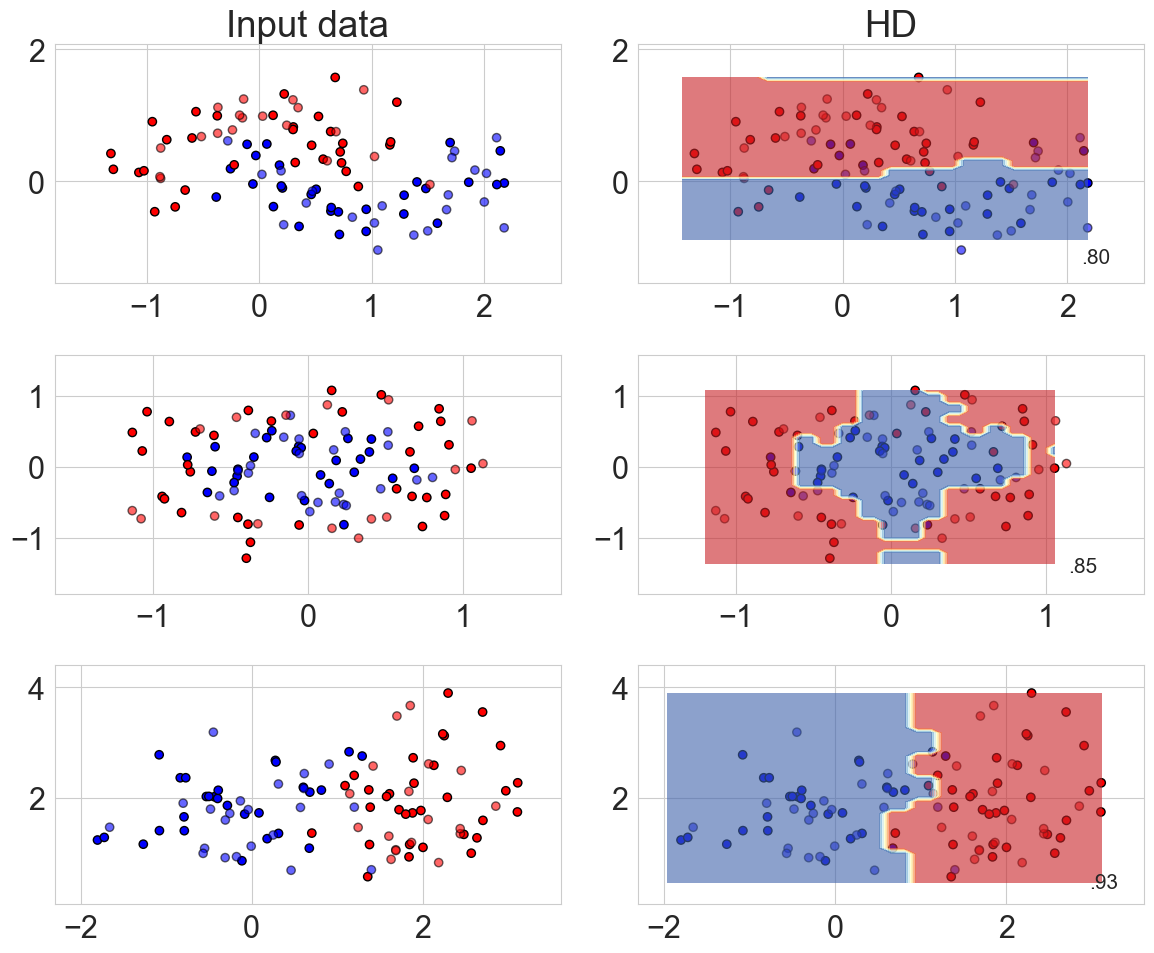

[{'Nearest Neighbors': 0.975,
  'Linear SVM': 0.875,
  'RBF SVM': 0.975,
  'Decision Tree': 0.95,
  'Neural Net': 0.9,
  'HD': 0.8},
 {'Nearest Neighbors': 0.925,
  'Linear SVM': 0.4,
  'RBF SVM': 0.875,
  'Decision Tree': 0.775,
  'Neural Net': 0.875,
  'HD': 0.85},
 {'Nearest Neighbors': 0.95,
  'Linear SVM': 0.925,
  'RBF SVM': 0.95,
  'Decision Tree': 0.95,
  'Neural Net': 0.95,
  'HD': 0.925}]

In [67]:
figure = plt.figure(figsize=(12, 10))
i = 1
names = ["HD"]
classifiers = [1]
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    # ax.set_xticks(())
    # ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        ex_0, ex_1, train_acc, x_lut, y_lut, xb, yb, x_pos, y_pos, train_preds = fit(X_train, y_train, bits=4, hyperdims=256)
        test_preds, score_test = score(ex_0, ex_1, X_test, y_test, xb, yb, x_lut, y_lut, x_pos, y_pos)
        test_acc[ds_cnt][name] = score_test
        
        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", 
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # ax.set_xticks(())
        # ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score_test).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

        xx, yy = np.meshgrid( np.arange(start=xb[0] - 0.5 * (xb[1]-xb[0]), stop=xb[-1] + 0.5 * (xb[1]-xb[0]), step=0.5 * (xb[1]-xb[0])), 
                                np.arange(start=yb[0] - 0.5 * (yb[1]-yb[0]), stop=yb[-1] + 0.5 * (yb[1]-yb[0]), step=0.5 * (yb[1]-yb[0])) )
        xin = np.c_[xx.ravel(), yy.ravel()]
        y_pred, _ = score(ex_0, ex_1, xin, np.zeros(xin.shape[0]), xb, yb, x_lut, y_lut, x_pos, y_pos)
        y_pred = np.round(y_pred).reshape(xx.shape)
        ax.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.6)
        

plt.tight_layout()
plt.show()
test_acc



 ## Increase data samples
 ### 100 to 500 samples
 ### More samples typically need more bits and more dims
 ### 4 to 6 bits, 64 to 1024 dims

In [68]:
from sklearn.datasets import make_circles, make_classification, make_moons

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, n_samples=500
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0, n_samples=500),
    make_circles(noise=0.2, factor=0.5, random_state=1, n_samples=500),
    linearly_separable,
]

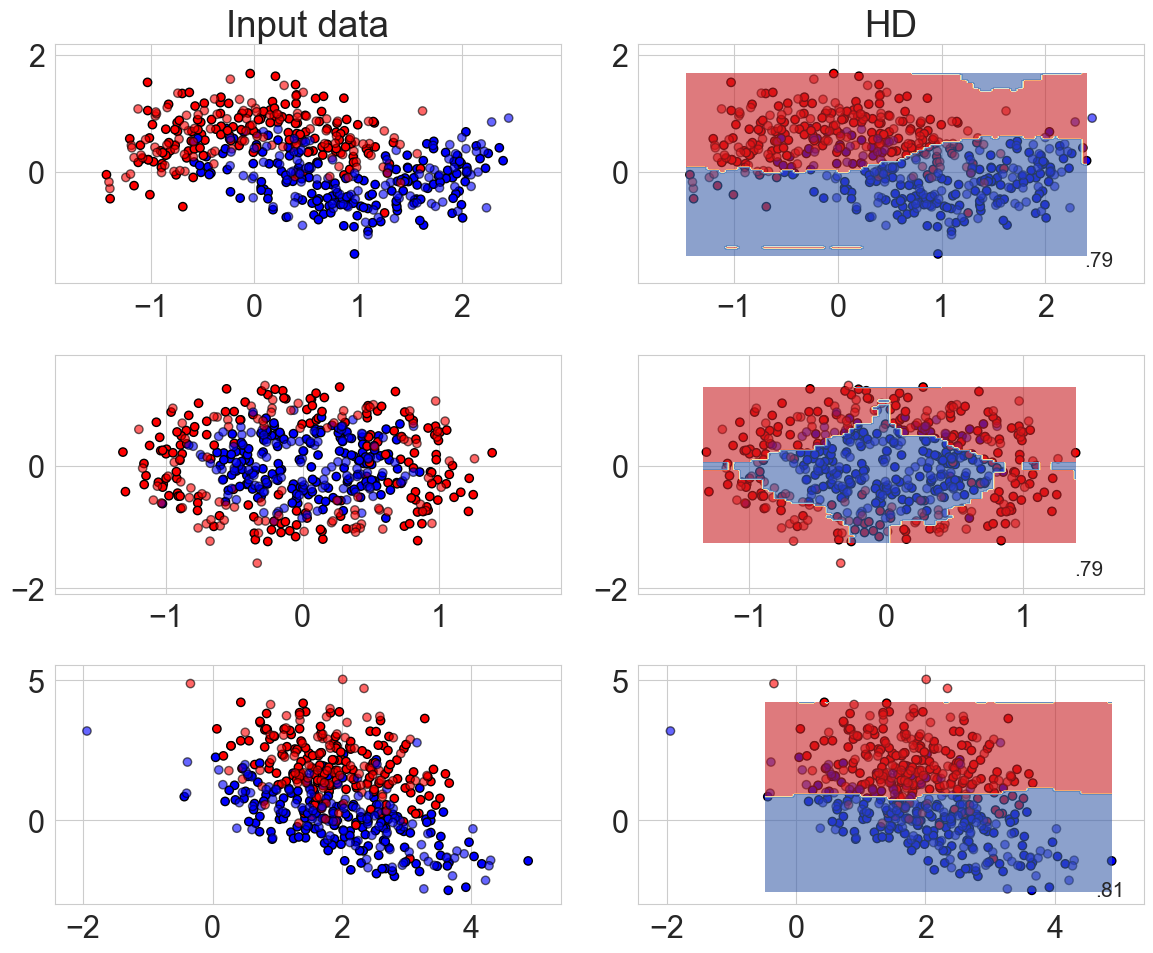

[{'Nearest Neighbors': 0.975,
  'Linear SVM': 0.875,
  'RBF SVM': 0.975,
  'Decision Tree': 0.95,
  'Neural Net': 0.9,
  'HD': 0.785},
 {'Nearest Neighbors': 0.925,
  'Linear SVM': 0.4,
  'RBF SVM': 0.875,
  'Decision Tree': 0.775,
  'Neural Net': 0.875,
  'HD': 0.79},
 {'Nearest Neighbors': 0.95,
  'Linear SVM': 0.925,
  'RBF SVM': 0.95,
  'Decision Tree': 0.95,
  'Neural Net': 0.95,
  'HD': 0.805}]

In [69]:
figure = plt.figure(figsize=(12, 10))
i = 1
names = ["HD"]
classifiers = [1]
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    # ax.set_xticks(())
    # ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        ex_0, ex_1, train_acc, x_lut, y_lut, xb, yb, x_pos, y_pos, train_preds = fit(X_train, y_train, bits=6, hyperdims=1024)
        test_preds, score_test = score(ex_0, ex_1, X_test, y_test, xb, yb, x_lut, y_lut, x_pos, y_pos)
        test_acc[ds_cnt][name] = score_test

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", 
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # ax.set_xticks(())
        # ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score_test).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

        xx, yy = np.meshgrid( np.arange(start=xb[0] - 0.5 * (xb[1]-xb[0]), stop=xb[-1] + 0.5 * (xb[1]-xb[0]), step=0.5 * (xb[1]-xb[0])), 
                                np.arange(start=yb[0] - 0.5 * (yb[1]-yb[0]), stop=yb[-1] + 0.5 * (yb[1]-yb[0]), step=0.5 * (yb[1]-yb[0])) )
        xin = np.c_[xx.ravel(), yy.ravel()]
        y_pred, _ = score(ex_0, ex_1, xin, np.zeros(xin.shape[0]), xb, yb, x_lut, y_lut, x_pos, y_pos)
        y_pred = np.round(y_pred).reshape(xx.shape)
        ax.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.6)
        

plt.tight_layout()
plt.show()
test_acc



## Pros and Cons of HD computing
### Binary operations - fast, scalable, better for edge computing
### Friendly to new hardware e.g., in-memory processors
### Accuracy can typically approach NN classifier or "heads" 
### Streaming training - update exemplars for every exemplar on-the-fly e.g., in few shots - next
### Not a deep architecture - works better with powerful external feature extractors - next